In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import sklearn
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()
# plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'weight' : 'normal'}
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', **font)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
### ATC data from DfT
vol = pd.read_csv('../DfT/DfT.csv')
vol['loc_key'] = vol.apply(lambda row: str(row['Site'])+row['Direction'][0], axis=1)
vol['datetime_key'] = vol.apply(lambda row: str(row['Date'])+'_'+str(row['Hour']), axis=1)
vol['site_id'] = vol['Site'].astype(int)
# print(vol.nunique(), np.max(vol['Date']), np.min(vol['Date']))
vol = vol[['loc_key', 'datetime_key', 'site_id', 'Volume']]
# vol.head()

### Travel time data from Google API
speed = pd.read_csv('../Google/Google.csv')
speed = speed.fillna(value={'Direction': '-'})
speed['loc_key'] = speed.apply(lambda row: str(row['Site'])+row['Direction'][0], axis=1)
speed['datetime_key'] = speed.apply(lambda row: str(row['Date'])+'_'+str(row['Hour']), axis=1)
# print(speed.nunique(), np.max(speed['Date']), np.min(speed['Date']))
speed = speed[['loc_key', 'datetime_key', 'distance', 'duration', 'duration_in_traffic', 'MajorMinor', 'Note', 'Road Class', 'dft_capacity', 'speed_limit(kph)']]
# speed.head()

### merge volume and speed data by location and time
data = pd.merge(vol, speed, how='inner', on=['loc_key', 'datetime_key'])
data['datetime'] =  pd.to_datetime(data['datetime_key'], format='%Y-%m-%d_%H')
print('Before merge, ATC has {} records, Google has {} records. Merged data has {} records'.format(vol.shape[0], speed.shape[0], data.shape[0]))
# data[data['loc_key']=='11N']
# print(data.groupby(['loc_key']).agg({'Note': 'first', 'Road Class': 'first', 'MajorMinor': 'first', 'dft_capacity': 'first'}))
print(np.unique(data['dft_capacity']))

/Users/bingyu/anaconda3/envs/cities/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Before merge, ACT has 30994 records, Google has 34989 records. Merged data has 17745 records
[ 900. 1300. 1650. 2800. 3300.]


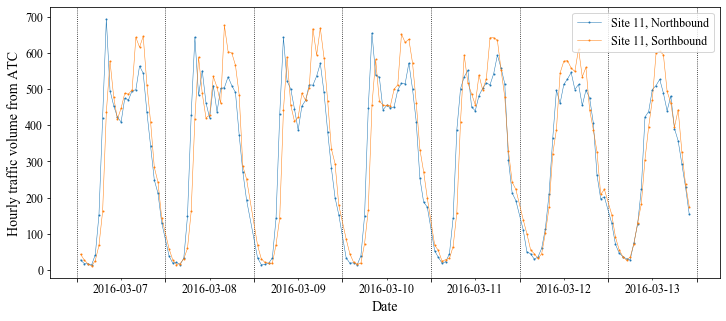

In [21]:
### Vehicle count visualization
sample_data_1 = data.loc[(data['loc_key']=='11N') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]
sample_data_2 = data.loc[(data['loc_key']=='11S') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(sample_data_1['datetime'], sample_data_1['Volume'], lw=0.5, marker='.', markersize=2, label='Site 11, Northbound')
ax.plot(sample_data_2['datetime'], sample_data_2['Volume'], lw=0.5, marker='.', markersize=2, label='Site 11, Sorthbound')
ax.set_xlabel('Date')
ax.set_ylabel('Hourly traffic volume from ATC')

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=0))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=12))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.xaxis.grid(True)
plt.legend()
plt.show()

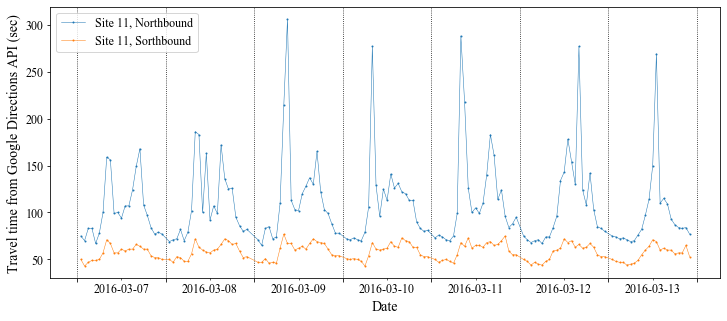

In [20]:
### Journey time visualization
sample_data_1 = data.loc[(data['loc_key']=='11N') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]
sample_data_2 = data.loc[(data['loc_key']=='11S') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(sample_data_1['datetime'], sample_data_1['duration_in_traffic'], lw=0.5, marker='.', markersize=2, label='Site 11, Northbound')
ax.plot(sample_data_2['datetime'], sample_data_2['duration_in_traffic'], lw=0.5, marker='.', markersize=2, label='Site 11, Sorthbound')
ax.set_xlabel('Date')
ax.set_ylabel('Travel time from Google Directions API (sec)')

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=0))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=12))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.xaxis.grid(True)
plt.legend()
plt.show()

Volume                   1474.000000
duration_in_traffic       192.000000
Volume_for_scale         1474.000000
n_Volume                    0.781548
n_duration_in_traffic       0.245211
Name: 1, dtype: float64
Volume                   659.000000
duration_in_traffic      178.000000
Volume_for_scale         659.000000
n_Volume                   0.949568
n_duration_in_traffic      0.400000
Name: 934, dtype: float64
Volume                   356.000000
duration_in_traffic       46.000000
Volume_for_scale         356.000000
n_Volume                   0.442236
n_duration_in_traffic      0.407080
Name: 10081, dtype: float64


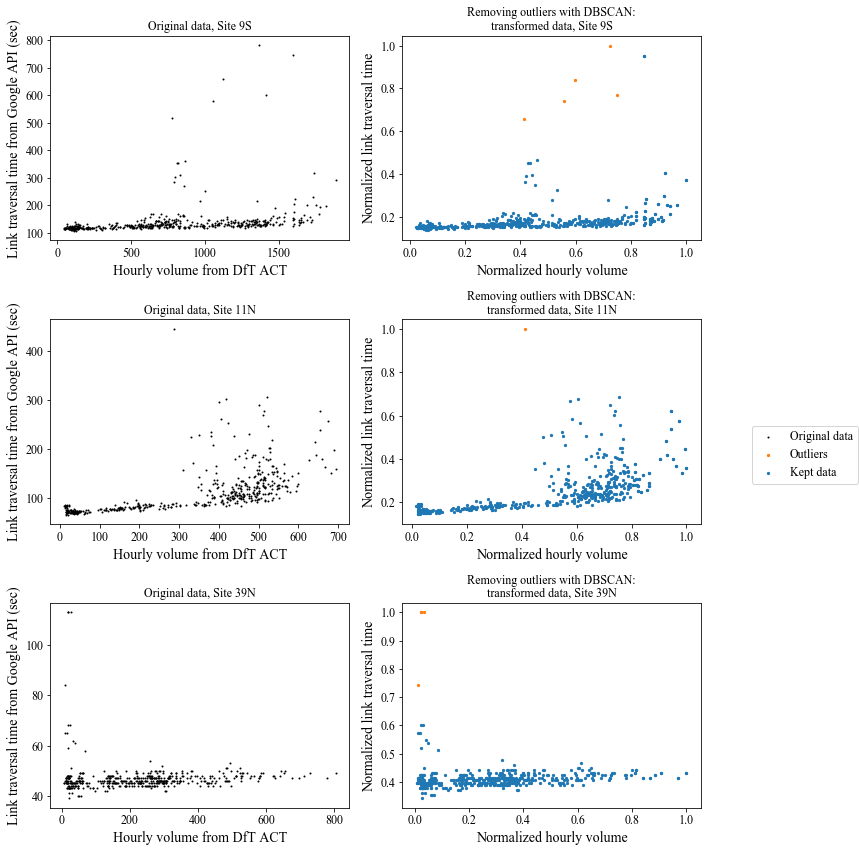

In [23]:
### DBSCAN code based on: https://machinelearningmastery.com/clustering-algorithms-with-python/
### DBSCAN explanation: https://scikit-learn.org/stable/modules/clustering.html#dbscan
fig, ax = plt.subplots(3,2, figsize=(10, 12))
fig.tight_layout()
row_id = 0
for site in ['9S', '11N', '39N']:
    sample_location = data.loc[data['loc_key']==site, ['Volume', 'duration_in_traffic']]
    sample_location['Volume_for_scale'] = np.where(sample_location['Volume']>100, sample_location['Volume'], 100)
    sample_location['n_Volume'] = sample_location['Volume']/sample_location['Volume'].max()
    sample_location['n_duration_in_traffic'] = sample_location['duration_in_traffic']/sample_location['duration_in_traffic'].max()
    print(sample_location.iloc[0])
    reserved_df = sample_location.loc[sample_location['n_Volume']>=0.8]
    sample_df = sample_location.loc[sample_location['n_Volume']<0.8]
    sample_data = sample_df[['n_Volume', 'n_duration_in_traffic']].values

    ### plot original data
    ax[row_id, 0].scatter(sample_location['Volume'], sample_location['duration_in_traffic'], s=1, c='k', label='Original data')
    ax[row_id, 0].set_xlabel('Hourly volume from DfT ATC')
    ax[row_id, 0].set_ylabel('Link traversal time from Google API (sec)')
    ax[row_id, 0].set_title('Original data, Site {}'.format(site))

    ### plot clustered data
    model = DBSCAN(eps=0.1, min_samples=5)
    yhat = model.fit_predict(sample_data)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        if (cluster==-1) or (len(row_ix[0])<5): c, label = u'#ff7f0e', 'Outliers'
        else: c, label = u'#1f77b4', 'Kept data'
        ax[row_id, 1].scatter(reserved_df['n_Volume'], reserved_df['n_duration_in_traffic'], s=5, c=u'#1f77b4')
        ax[row_id, 1].scatter(sample_data[row_ix, 0], sample_data[row_ix, 1], s=5, c=c, label=label)
    ax[row_id, 1].set_xlabel('Normalized hourly volume')
    ax[row_id, 1].set_ylabel('Normalized link traversal time')
    ax[row_id, 1].set_title('Removing outliers with DBSCAN:\ntransformed data, Site {}'.format(site))
    row_id += 1
handles_1, labels_1 = ax[0,0].get_legend_handles_labels()
handles_2, labels_2 = ax[0,1].get_legend_handles_labels()
fig.legend(handles_1+handles_2, labels_1+labels_2, bbox_to_anchor=(1.2, 0.5), ncol=1, prop={'size': 12})
plt.tight_layout()
plt.show()

['9N', '9S', '11N', '11S', '15N', '15S', '19E', '19W', '22N', '22S', '25W', '27E', '27W', '31N', '31S', '33N', '33S', '35N', '35S', '36N', '36S', '39N', '39S', '40E', '40W', '42N', '42S', '43E', '43W', '48N', '48S', '66N', '66S', '67N', '67S', '68E', '68W', '74N', '74S']
Data has 17745 points before removing outliers, 17679 after removing outliers


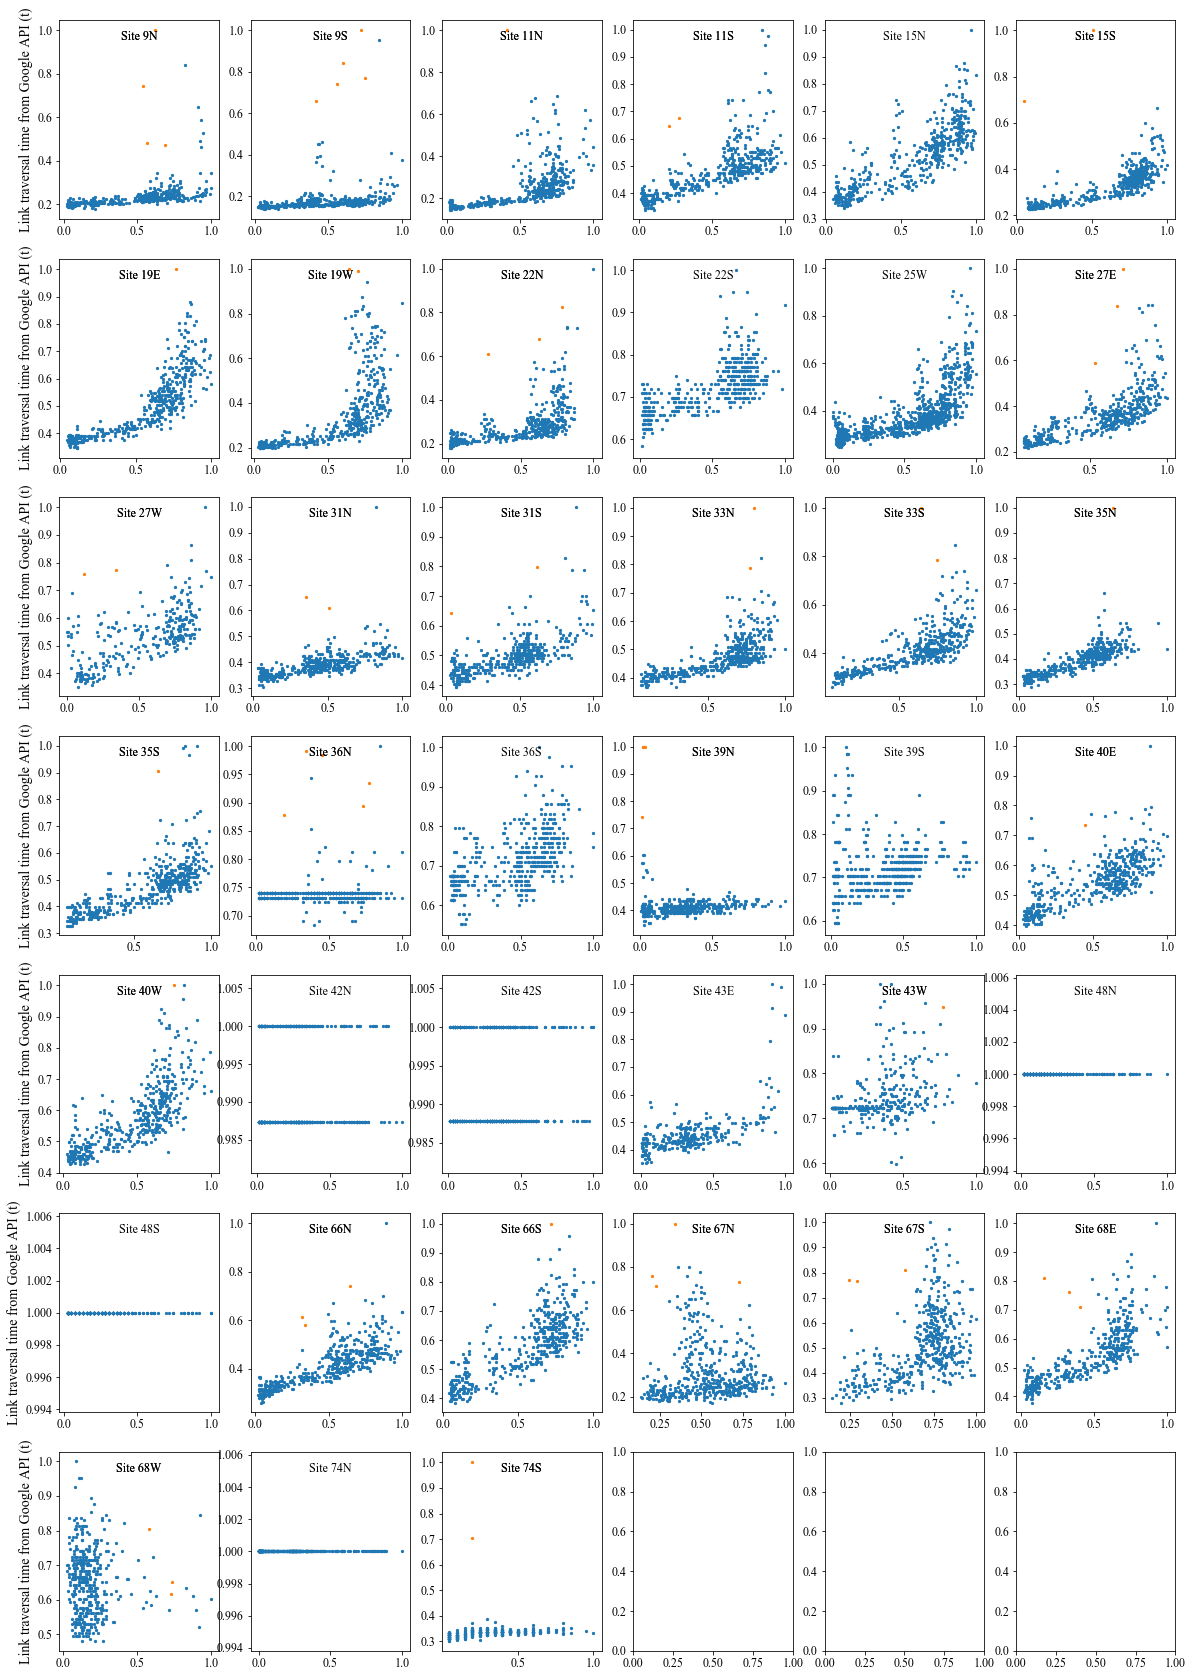

In [7]:
### Showing clustering results for all data
loc_list = data.groupby(['site_id', 'loc_key']).size().index.get_level_values('loc_key').tolist()
print(loc_list)
# print(data.groupby(['site_id', 'loc_key']).size())

filtered_data_list = []
loc_cnt = -1  
fig, ax = plt.subplots(7,6, figsize=(20, 30))
for loc_cnt in range(len(loc_list)):
    row = loc_cnt//6
    col = loc_cnt%6
    ### normalize volume and delay for clustering    
    sample_location = data.loc[data['loc_key']==loc_list[loc_cnt]].copy()
    sample_location['Volume_for_scale'] = np.where(sample_location['Volume']>100, sample_location['Volume'], 100)
    sample_location['n_Volume'] = sample_location['Volume']/sample_location['Volume'].max()
    sample_location['n_duration_in_traffic'] = sample_location['duration_in_traffic']/sample_location['duration_in_traffic'].max()
    reserved_df = sample_location.loc[sample_location['n_Volume']>=0.8]
    sample_df = sample_location.loc[sample_location['n_Volume']<0.8]
    sample_data = sample_df[['n_Volume', 'n_duration_in_traffic']].values
    ### DBSCAN model
    model = DBSCAN(eps=0.1, min_samples=5)
    yhat = model.fit_predict(sample_data)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        if (cluster==-1): c=u'#ff7f0e' 
        else: c=u'#1f77b4'
        ax[row, col].scatter(sample_data[row_ix, 0], sample_data[row_ix, 1], s=5, c=c, label=cluster)
        ax[row, col].text(.5,.9,'Site {}'.format(loc_list[loc_cnt]), horizontalalignment='center', transform=ax[row, col].transAxes)
        if row==9: ax[row, col].set_xlabel('Hourly volume from DfT ATC')
        if col==0: ax[row, col].set_ylabel('Link traversal time from Google API (t)')
    ax[row, col].scatter(reserved_df['n_Volume'], reserved_df['n_duration_in_traffic'], s=5, c=u'#1f77b4')
    filtered_data_list.append(sample_df.iloc[np.where(yhat != -1)])
    filtered_data_list.append(reserved_df)
filtered_data = pd.concat(filtered_data_list)
print('Data has {} points before removing outliers, {} after removing outliers'.format(data.shape[0], filtered_data.shape[0]))

In [24]:
### normalize volume and travel time
### free flow time (travel time normalization factor): lowest 95 percentile of all observed travel time
### saturation volume (volume normalization factor): average volume of 10 observations when travel_time/free_flow_time is closest to 2.
data_grp = filtered_data[~filtered_data['loc_key'].isin(['36N', '42N', '42S', '48N', '48S', '68W', '74N', '74S', '22S', '36S', '39S', '43W', '31N', '39N', '9N'])].groupby('loc_key')
### 22S, 36S, 39S, 43W: maximum delay < 1.8
data_norm_list = []
for nm, grp in data_grp:
    df = grp.copy()
    df['t_95pct'] = np.percentile(df['duration_in_traffic'], 5)
    df['t_norm'] = df['duration_in_traffic']/df['t_95pct']
    sat_df = df[(df['t_norm']>1.8) & (df['t_norm']<2.2)]
    if sat_df.shape[0] == 0:
        print(nm)
        sat_df = df.copy()
        sat_df['abs_t_norm_minus_2'] = np.abs(sat_df['t_norm'] - 2)
        sat_df = sat_df.nsmallest(30, 'abs_t_norm_minus_2')
    df['v_sat'] = np.percentile(sat_df['Volume'], 95)#np.average(sat_df['Volume'])
    df['v_norm'] = df['Volume']/df['v_sat']
#     if nm=='9S': print(sat_df, df.iloc[0])
    data_norm_list.append(df)
data_norm = pd.concat(data_norm_list)
print(data_norm.groupby('loc_key').agg({'distance': 'first', 'speed_limit(kph)': 'first', 't_95pct': 'first', 'dft_capacity':'first', 'v_sat': 'first'}).reset_index(drop=False))

   loc_key  distance  speed_limit(kph)  t_95pct  dft_capacity    v_sat
0      11N       561              48.0     70.0        1650.0   589.90
1      11S       561              48.0     46.0        1650.0   648.60
2      15N      1039              48.0    108.0        1650.0   683.30
3      15S      1039              48.0     96.0        1650.0   508.50
4      19E       656              48.0     58.0        1650.0   851.40
5      19W       656              48.0     76.0        1650.0   777.80
6      22N       759              48.0     70.0        1650.0   375.50
7      25W       631              48.0     58.0        1650.0   995.50
8      27E      1001              48.0    103.0        1650.0   627.55
9      27W      1001              48.0    104.0        1650.0   614.50
10     31S       463              32.0     43.0        1650.0   593.70
11     33N       577              32.0     53.0        1650.0   375.00
12     33S       577              32.0     70.0        1650.0   459.80
13    

(24, 7) 1.3829576121031053 0.3411798161329411


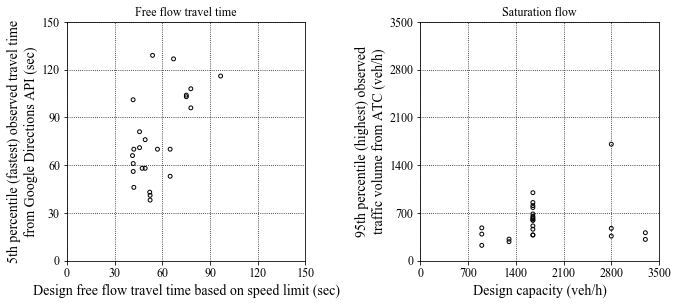

In [25]:
### free flow time, observed vs design
fft_grp = data_norm.groupby('loc_key').agg({'distance': 'first', 'speed_limit(kph)': 'first', 't_95pct': 'first', 'dft_capacity':'first', 'v_sat': 'first'}).reset_index(drop=False)
fft_grp['t_design'] = fft_grp['distance']/fft_grp['speed_limit(kph)']*3.6
print(fft_grp.shape, np.mean(fft_grp['t_95pct']/fft_grp['t_design']), np.mean(fft_grp['v_sat']/fft_grp['dft_capacity']))
# print(fft_grp)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.tight_layout()
### Free flow time
ax[0].scatter(fft_grp['t_design'], fft_grp['t_95pct'], s=15, facecolors='none', edgecolors='k')
ax[0].set_xlim(0, 150)
ax[0].set_ylim(0, 150)
ax[0].set_xticks(np.arange(0, 160, 30))
ax[0].set_yticks(np.arange(0, 160, 30))
ax[0].set_xlabel('Design free flow travel time based on speed limit (sec)')
ax[0].set_ylabel('5th percentile (fastest) observed travel time\nfrom Google Directions API (sec)')
ax[0].set_title('Free flow travel time')
ax[0].grid(True)
ax[0].set_aspect('equal', adjustable='box')
### Capacity
ax[1].scatter(fft_grp['dft_capacity'], fft_grp['v_sat'], s=15, facecolors='none', edgecolors='k')
ax[1].set_xlim(0, 3500)
ax[1].set_ylim(0, 3500)
ax[1].set_xticks(np.arange(0, 4100, 700))
ax[1].set_yticks(np.arange(0, 4100, 700))
ax[1].set_xlabel('Design capacity (veh/h)')
ax[1].set_ylabel('95th percentile (highest) observed\ntraffic volume from ATC (veh/h)')
ax[1].set_title('Saturation flow')
ax[1].grid(True)
ax[1].set_aspect('equal', adjustable='box')
### Plotting
plt.rc('grid', linestyle=":", color='black')
plt.show()

{'11N': 466, '11S': 465, '15N': 467, '15S': 465, '19E': 466, '19W': 465, '22N': 464, '25W': 932, '27E': 464, '27W': 285, '31S': 465, '33N': 465, '33S': 465, '35N': 466, '35S': 466, '40E': 466, '40W': 466, '43E': 329, '66N': 464, '66S': 466, '67N': 463, '67S': 464, '68E': 420, '9S': 462}
0.42750175364570453 1.1560005103117599 (462, 20)
1.2339397368906933 1.6760726239369284 (466, 20)
0.6689120280622252 0.2370151713383399 (463, 20)


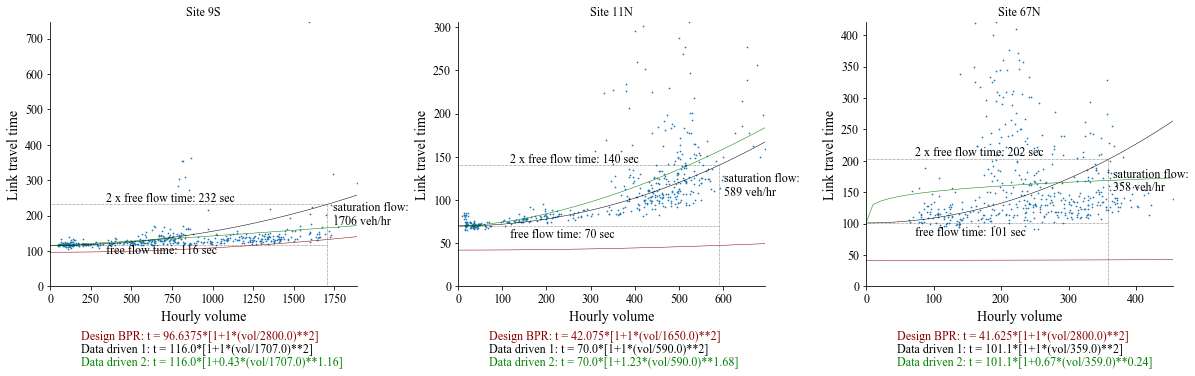

In [26]:
from lmfit import Model
print(data_norm.groupby('loc_key').size().to_dict())
selected_sites = ['9S', '11N', '67N']

def fitfun(x, t0, alpha, beta, cap):
    return t0*(1+alpha*(x/cap)**beta)

fig, ax = plt.subplots(1, 3, figsize=(18,6))
fig.tight_layout(pad=6)
col_id = -1
for site in selected_sites:
    col_id += 1
    ### site data
    df = data_norm.loc[data_norm['loc_key']==site]
    ### infer fft and cap
    fft = df['t_95pct'].iloc[0]
    cap = df['v_sat'].iloc[0]
    ### observed data
    ax[col_id].set_title('Site {}'.format(site))
    ax[col_id].scatter(df['Volume'], df['duration_in_traffic'], s=0.5)
    ax[col_id].set_xlim([0, np.max(df['Volume'])])
    ax[col_id].set_ylim([0, np.max(df['duration_in_traffic'])])
    ax[col_id].set_xlabel('Hourly volume')
    ax[col_id].set_ylabel('Link travel time')
    # Hide the right and top spines
    ax[col_id].spines['right'].set_visible(False)
    ax[col_id].spines['top'].set_visible(False)
    ax[col_id].spines['left'].set_position('zero')
    ax[col_id].spines['bottom'].set_position('zero')
    # Only show ticks on the left and bottom spines
    ax[col_id].yaxis.set_ticks_position('left')
    ax[col_id].xaxis.set_ticks_position('bottom')
    # Add capacity reference
    ax[col_id].vlines(x=cap, ymin=0, ymax=fft*2, lw=0.5, ls=':')
    ax[col_id].hlines(y=fft*2, xmin=0, xmax=cap, lw=0.5, ls=':')
    ax[col_id].hlines(y=fft, xmin=0, xmax=cap, lw=0.5, ls=':')
    ax[col_id].text(cap*1.02, fft*1.5, 'saturation flow:\n{} veh/hr'.format(int(cap)))
    ax[col_id].text(cap/5, fft*2.05, '2 x free flow time: {} sec'.format(int(fft*2)))
    ax[col_id].text(cap/5, fft*0.8, 'free flow time: {} sec'.format(int(fft)))
    
    ### Add DfT capacity and speed limit
    x_curve = np.linspace(0, np.max(df['Volume'])*1.1, 50)
    dft_fft = df['distance'].iloc[0]/df['speed_limit(kph)'].iloc[0]*3.6 ### Believed free flow time in seconds
    dft_cap = df['dft_capacity'].iloc[0]
    y_dft = (1 + (x_curve/dft_cap)**2)*dft_fft
    ax[col_id].plot(x_curve, y_dft, c='darkred', lw=0.5, label='DfT BPR')
    ### Data driven 1
    y_m1 = (1 + (x_curve/cap)**2)*fft
    ax[col_id].plot(x_curve, y_m1, c='k', lw=0.5, label='Data driven 1')
    
    ### Fit non-linear
    mymodel = Model(fitfun)
    params = mymodel.make_params(alpha=1, beta=2)
    params['t0'].vary = False
    params['cap'].vary = False
    params['t0'].value = fft
    params['cap'].value = cap
    result = mymodel.fit(df['duration_in_traffic'], params, x=df['Volume'])
    r_alpha = result.params['alpha'].value
    r_beta = result.params['beta'].value
    print(r_alpha, r_beta, df.shape)
    ax[col_id].plot(x_curve, fitfun(x_curve, fft, r_alpha, r_beta, cap), c='g', lw=0.5, label='Data driven 2')
    
    ### text
    ax[col_id].text(0.1, -0.2, 'Design BPR: t = {}*[1+{}*(vol/{})**{}]'.format(dft_fft, 1, dft_cap, 2), c='darkred', transform = ax[col_id].transAxes)
    ax[col_id].text(0.1, -0.25, 'Data driven 1: t = {}*[1+{}*(vol/{})**{}]'.format(round(fft,1), 1, round(cap), 2), c='k', transform = ax[col_id].transAxes)
    ax[col_id].text(0.1, -0.3, 'Data driven 2: t = {}*[1+{}*(vol/{})**{}]'.format(round(fft,1), round(r_alpha, 2), round(cap), round(r_beta, 2)), c='g', transform = ax[col_id].transAxes)
    

['11N' '11S' '15N' '15S' '19E' '19W' '22N' '25W' '27E' '27W' '31S' '33N'
 '33S' '35N' '35S' '40E' '40W' '43E' '66N' '66S' '67N' '67S' '68E' '9S']
555
718
    Model Quartile Site       MAE_t      MAE_u
259   DfT       Q5  43E  169.681703  30.603169
300   DfT       Q1  67N   78.635982  30.842066
301   DfT       Q2  67N   94.749655  31.600631
302   DfT       Q3  67N  145.828317  35.358112
303   DfT       Q4  67N  111.039675  33.468366
304   DfT       Q5  67N  110.435570  33.593201
316   DfT       Q2  67S   95.352538  30.140474
317   DfT       Q3  67S  117.357630  31.772961
318   DfT       Q4  67S  167.788242  34.885495
319   DfT       Q5  67S  151.759438  33.618095


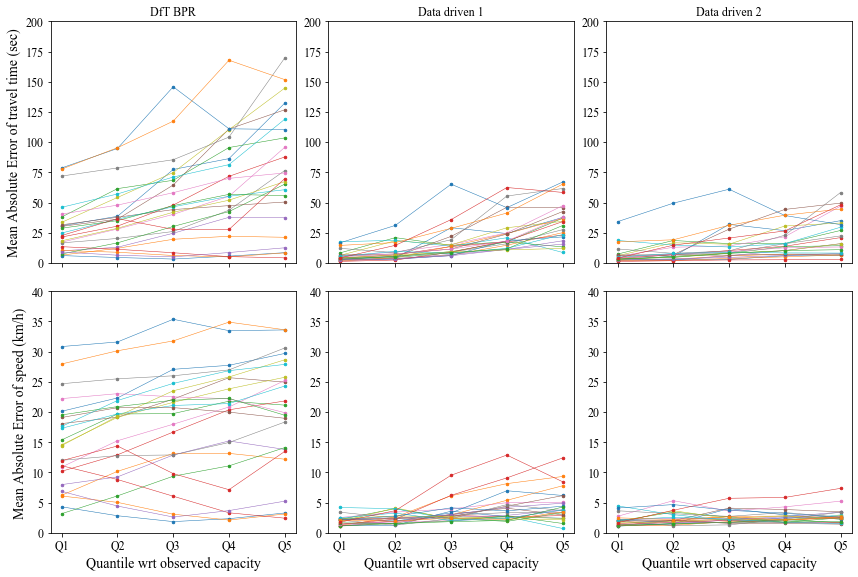

In [42]:
### Mean Absolute Error

def mae(alpha, beta, t0, vc, x_obs, y_obs):
    y_model = t0*(1+alpha*(x_obs/vc)**beta)
    return np.mean(np.absolute(y_model-y_obs))

def mae_speed(alpha, beta, t0, vc, x_obs, y_obs, length):
    y_model = t0*(1+alpha*(x_obs/vc)**beta)
    speed_model = length/y_model
    speed_obs = length/y_obs
    return np.mean(np.absolute(speed_model-speed_obs))*3.6

def fitfun(x, t0, alpha, beta, cap):
    return t0*(1+alpha*(x/cap)**beta)

print(np.unique(data_norm['loc_key']))
mae_l = []
for nm, grp in data_norm.groupby('loc_key'):
#     print(nm)
    cap_obs = grp['v_sat'].iloc[0]
    road_length = grp['distance'].iloc[0]
    if nm in ['67N', '67S']: print(road_length)
    quarter_data = {'Q1':grp[grp['Volume']<=cap_obs*0.25],
                    'Q2':grp[(grp['Volume']<=cap_obs*0.5) & (grp['Volume']>cap_obs*0.25)],
                    'Q3':grp[(grp['Volume']<=cap_obs*0.75) & (grp['Volume']>cap_obs*0.5)],
                    'Q4':grp[(grp['Volume']<=cap_obs*1) & (grp['Volume']>cap_obs*0.75)],
                    'Q5':grp[grp['Volume']>cap_obs]}
    ### DfT coefficients
    alpha, beta, t0, vc = 1, 2, grp['distance'].iloc[0]/grp['speed_limit(kph)'].iloc[0]*3.6, grp['dft_capacity'].iloc[0]
    for q_id, q_data in quarter_data.items():
        mae_l.append(['DfT', q_id, nm, 
                  mae(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic']),
                  mae_speed(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic'], road_length)])
    ### Data driven 1
    alpha, beta, t0, vc = 1, 2, grp['t_95pct'].iloc[0], grp['v_sat'].iloc[0]
    for q_id, q_data in quarter_data.items():
        mae_l.append(['DD1', q_id, nm, 
                  mae(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic']),
                  mae_speed(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic'], road_length)])
    ### Data driven 2
    t0, vc = grp['t_95pct'].iloc[0], grp['v_sat'].iloc[0]
    mymodel = Model(fitfun)
    params = mymodel.make_params(alpha=1, beta=2)
    params['t0'].vary = False
    params['cap'].vary = False
    params['t0'].value = t0
    params['cap'].value = vc
    result = mymodel.fit(grp['duration_in_traffic'], params, x=grp['Volume'])
    alpha = result.params['alpha'].value
    beta = result.params['beta'].value
    for q_id, q_data in quarter_data.items():
        mae_l.append(['DD2', q_id, nm, 
                  mae(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic']),
                  mae_speed(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic'], road_length)])
#     break
mae_df = pd.DataFrame(mae_l, columns=['Model', 'Quartile', 'Site', 'MAE_t', 'MAE_u'])
print(mae_df[mae_df['MAE_u']>30])

fig, ax = plt.subplots(2,3, figsize=(12,8), sharex=True)
ax[0,0].set_ylabel('Mean Absolute Error of travel time (sec)')
ax[1,0].set_ylabel('Mean Absolute Error of speed (km/h)')
ax[0,0].set_title('DfT BPR')
ax[0,1].set_title('Data driven 1')
ax[0,2].set_title('Data driven 2')
plt.setp(ax[0,:], ylim=[0,200])
plt.setp(ax[1,:], ylim=[0,40], xlabel='Quantile wrt observed capacity')
fig.tight_layout(pad=0.5)
for site, grp in mae_df.groupby('Site'):
    col_id = -1
    for model in ['DfT', 'DD1', 'DD2']:
        col_id += 1
        ### Travel time
        ax[0,col_id].plot(grp.loc[grp['Model']==model, 'Quartile'], grp.loc[grp['Model']==model, 'MAE_t'], ls='-', lw=0.5, marker='.', ms=5)
        ### Speed
        ax[1,col_id].plot(grp.loc[grp['Model']==model, 'Quartile'], grp.loc[grp['Model']==model, 'MAE_u'], ls='-', lw=0.5, marker='.', ms=5)
# mae_df

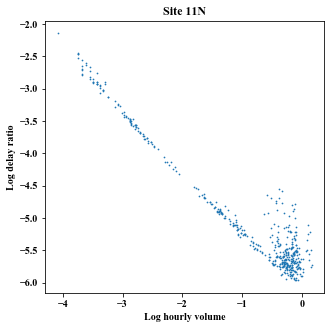

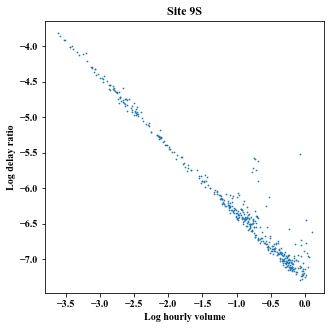

In [17]:
### transform
selected_sites = ['11N', '9S']

for site in selected_sites:
    ### site data
    df = data_norm.loc[data_norm['loc_key']==site]
    ### infer fft and cap
    fft = df['t_95pct'].iloc[0]
    cap = df['v_sat'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title('Site {}'.format(site))
    tr_y = np.log((df['duration_in_traffic']/fft)/df['Volume'])
    tr_x = np.log(df['Volume']/cap)
    ax.scatter(tr_x, tr_y, s=0.5)
#     ax.set_xlim([0, np.max(tr_x)])
#     ax.set_ylim([0, np.max(tr_y)])
    ax.set_xlabel('Log hourly volume')
    ax.set_ylabel('Log delay ratio')
    # Hide the right and top spines
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_position('zero')
#     ax.spines['bottom'].set_position('zero')
    # Only show ticks on the left and bottom spines
#     ax.yaxis.set_ticks_position('left')
#     ax.xaxis.set_ticks_position('bottom')
